In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import glob

In [2]:
BOLTZMAN  = 1.380658e-23 #                 Boltzman constant (J/K)
AVOGADRO  = .602214199e24 #                 Avogadro constant (1/mol)
MD        = 28.9644e-3 #                    molar mass dry air (kg/mol)
MV        = 18.0153e-3 #                    molae mass water vapor (kg/mol)
r_v       = (AVOGADRO)*(BOLTZMAN)/(MV) #    gas constant for water vapor (J/(kg-K))
r_d       = (AVOGADRO)*(BOLTZMAN)/(MD) #    gas constant for dry air (J/(kg-K))
cp        = 7./2*(r_d) #                   specific heat of air (J/(kg-K))
L        = 2.5008e6
rho_ref       = 1.
p_ref = 1000. #   reference  pressure, hPa

In [3]:
print(cp)

1004.7097403952084


In [55]:
path="/lustre/ytzheng/"
Casename = 'ASTEX_cold2.6'
Casename1 = 'ASTEX_warm2.6'

f = xr.open_mfdataset(path + Casename + '/' +  '*600.nc',
                      combine = 'by_coords',decode_cf = False)

f1 = xr.open_mfdataset(path + Casename1 + '/' + '*600.nc',
                      combine = 'by_coords',decode_cf = False)

In [71]:
f1 = f1.assign_coords(z=f.z.values)
ind_time = 30

In [53]:
# f = f.isel(z = slice(0, 400))
# f1 = f1.isel(z = slice(0, 400))
# ind_time = 30

In [9]:
#get the cloud base height
with xr.open_mfdataset(path + Casename + '/' +  '*N100.nc',
                      combine = 'by_coords',decode_cf = False) as ff:

#     zcb = ff['zcb'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     zct = ff['zct'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     p = ff['PRES'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     pott = ff['THETA'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     lpott = ff['THETAL'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     qv = ff['QV'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')/1000.
#     qt = ff['QT'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')/1000.
     
    zcb = ff['zcb'].values[ind_time]
    zct = ff['zct'].values[ind_time]   
    p = ff['PRES'][ind_time]
    pott = ff['THETA'][ind_time]
    lpott = ff['THETAL'][ind_time]
    qv = ff['QV'][ind_time]/1000.
    qt = ff['QT'][ind_time]/1000.   
    
with xr.open_mfdataset(path + Casename1 + '/' +  '*N100.nc',
                      combine = 'by_coords',decode_cf = False) as ff:

#     zcb1 = ff['zcb'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     zct1 = ff['zct'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     p1 = ff['PRES'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     pott1 = ff['THETA'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     lpott1 = ff['THETAL'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')
#     qv1 = ff['QV'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')/1000.
#     qt1 = ff['QT'].isel(time = slice(ind_time - 1, ind_time)).mean(dim = 'time')/1000.
    
    zcb1 = ff['zcb'].values[ind_time]
    zct1 = ff['zct'].values[ind_time] 
    p1 = ff['PRES'][ind_time]
    pott1 = ff['THETA'][ind_time]
    lpott1 = ff['THETAL'][ind_time]
    qv1 = ff['QV'][ind_time]/1000.
    qt1 = ff['QT'][ind_time]/1000.

In [10]:
z = f['z']
x = f['x']/1000.
y = f['y']/1000.
time = f['time']

myfontsize = 12

In [11]:
from sam_sat import *

def yzmixingdiagram(pott_in, qv_in, pres_in):
    BOLTZMAN  = 1.380658e-23 #                 Boltzman constant (J/K)
    AVOGADRO  = .602214199e24 #                 Avogadro constant (1/mol)
    MD        = 28.9644e-3 #                    molar mass dry air (kg/mol)
    MV        = 18.0153e-3 #                    molae mass water vapor (kg/mol)
    r_v       = (AVOGADRO)*(BOLTZMAN)/(MV) #    gas constant for water vapor (J/(kg-K))
    r_d       = (AVOGADRO)*(BOLTZMAN)/(MD) #    gas constant for dry air (J/(kg-K))
    cp        = 7./2*(r_d) #                   specific heat of air (J/(kg-K))
    L        = 2.5008e6
    rho_ref       = 1.
    p_ref = 1000. #   reference  pressure, hPa
    
    #mixing diagram starts with environmental air, so no liquid water
    lpott_in = pott_in
    qt_in = qv_in
    
    #compute buoyancy, i.e. virtual potential temperature
    vpott_const = lpott_in*(1. + 0.61*qt_in)

    #vary the lpott
    pott_out = pott_in - 5. + 0.001*np.arange(10001) 
    
    #Unsaturated phase: lpott and qt are easily computed with the constraints of constant buoyancy 
    lpott_out = pott_out
    qt_out = ((vpott_const/pott_out) - 1.)/0.61
    
    #compute saturation qv
    tmp_out = pott_out/((p_ref/pres_in)**(r_d/cp))
    pres_out = np.zeros(10001) + pres_in
    
    qsat_out = qsatw(tmp_out,pres_out)
#     qsat_out = np.array(qsat_out, copy=True)

    #Saturated phase
    ind = np.where(qt_out > qsat_out)[0]
    count = len(ind)
    
    if count > 0:
    #for saturated parcels there are four equations for solving the qt and lpott
    #1. lpott formula
    #2. qt = qv + ql
    #3. qv formula that is set to vpott_const
    #4. CC equation
    #
    # Correspondingly, there are four knowns: qt, lpott, pott, and qv
    #
    #Solving the equations are not difficult, but cumbersome, so I solve them numerically
    
    #surveying a wide range of pott, there must be one that meet the set of equations
        pott_try = pott_in - 10. + 0.001*np.arange(20001)
        tmp_try = pott_try/((p_ref/pres_in)**(r_d/cp))
        pres_try = np.zeros(20001) + pres_in
        qsat_try = qsatw(tmp_try,pres_try)
        
        ql_try = 1. + 0.61*qsat_try-(vpott_const/pott_try)
        lpott_try = pott_try - (L/cp)*ql_try

        #these ranges of pott corresponds an equal-size array of lpott. 
        #Thank to the magic of the "value_locate function", we can find the correspondences for lpott used for plotting the diagram    
        use = lpott_out[ind]
        
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        for i in np.arange(count):
            idx_tmp = find_nearest(lpott_try, use[i])
            lpott_out[ind[i]] = lpott_try[idx_tmp]
            qt_out[ind[i]] = qsat_try[idx_tmp] + ql_try[idx_tmp]

    out = np.vstack((lpott_out,qsat_out,qt_out))
    return out

In [74]:
qt_3D = f['QN'] + f['QV']
pott_3D = f['TABS']*((p_ref/f['p'])**(r_d/cp))
lpott_3D = pott_3D - (pott_3D/f['TABS'])*(L/cp)*f['QN']/1000.

qt1_3D = f1['QN'] + f1['QV']
pott1_3D = f1['TABS']*((p_ref/f1['p'])**(r_d/cp))
lpott1_3D = pott1_3D - (pott1_3D/f1['TABS'])*(L/cp)*f1['QN']/1000.

In [13]:
mixingplot = yzmixingdiagram(pott.sel(z = zcb, method="nearest").values,
                             qv.sel(z = zcb, method="nearest").values,
                             p.sel(z = zcb, method="nearest").values)

mixingplot1 = yzmixingdiagram(pott1.sel(z = zcb1, method="nearest").values,
                             qv1.sel(z = zcb1, method="nearest").values,
                             p1.sel(z = zcb1, method="nearest").values)

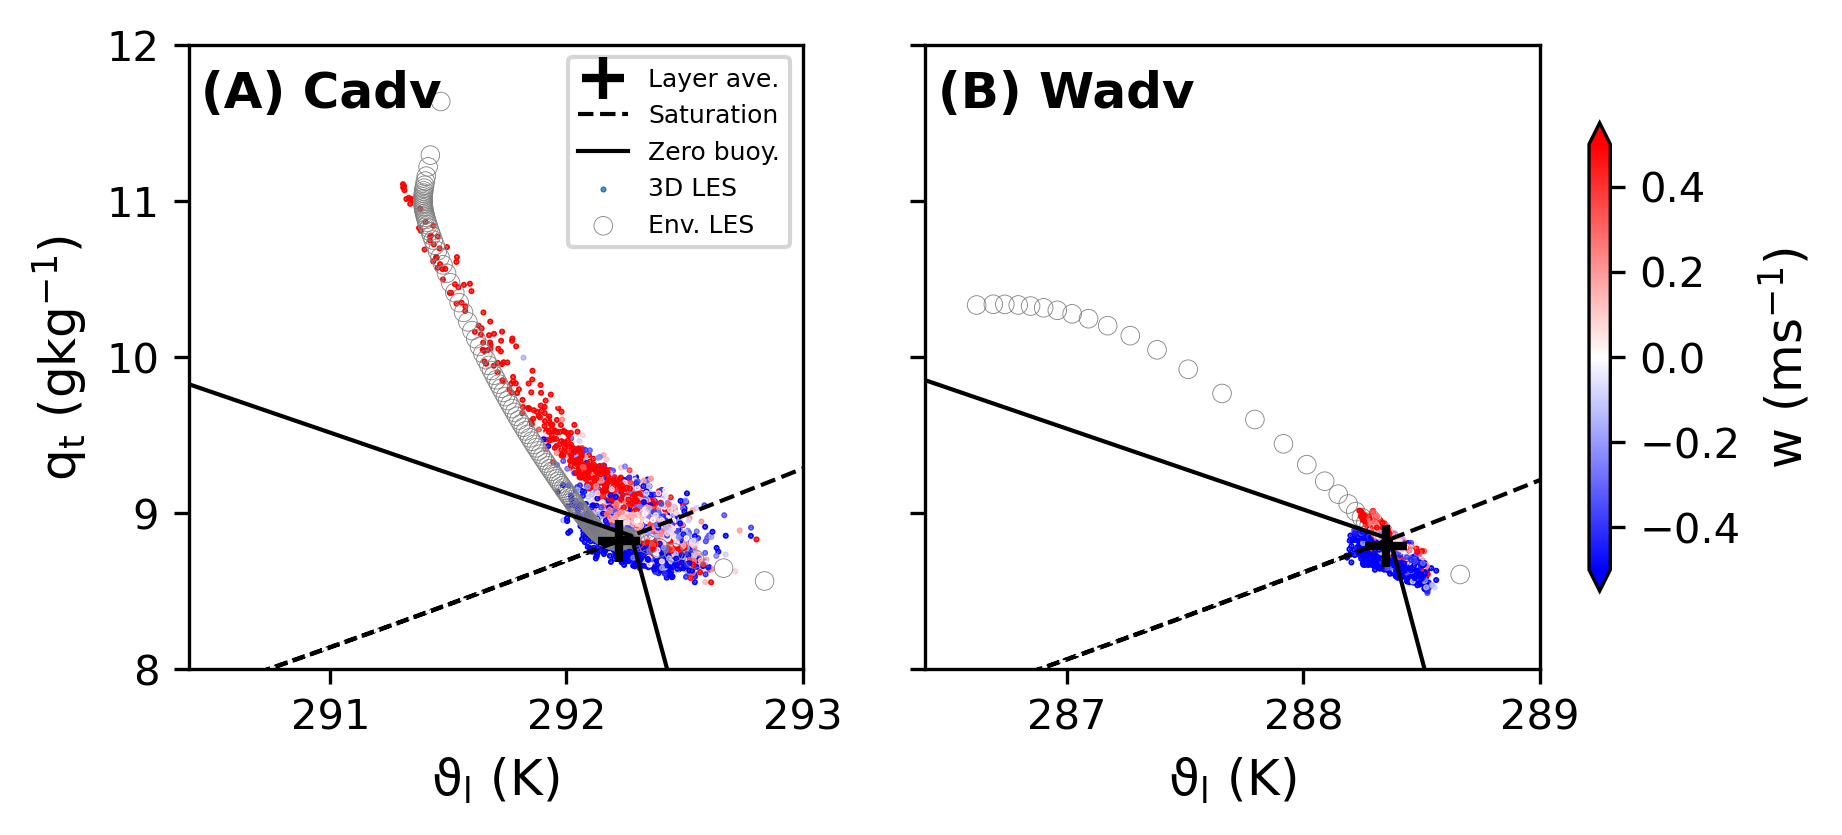

In [80]:
fig, axs = plt.subplots(ncols = 2,
                        nrows = 1,
                        sharex = False, sharey = True,
                        figsize=(18/2.54, (7)/2.54), dpi = 300)

#-----CADV
a = axs[0].plot(lpott.sel(z = zcb, method="nearest"),
                1000.*qt.sel(z = zcb, method="nearest"),
                '+', label = 'Layer ave.',color = 'black', markersize=10, markeredgewidth=2)

axs[0].set_xlabel(r"$\mathrm{\vartheta_l \ (K)}$", fontsize=myfontsize)
axs[0].set_ylabel(r"$\mathrm{q_t \ (gkg^{-1})}$", fontsize=myfontsize)
axs[0].set_xlim([290.4, 293])
axs[0].set_ylim([8., 12])

#mixing lines
a = axs[0].plot(mixingplot[0],
                1000.*mixingplot[1],
                linewidth=1, linestyle = '--',label = 'Saturation', color = 'black')

a = axs[0].plot(mixingplot[0],
                1000.*mixingplot[2],
                linewidth=1, linestyle = '-',label = 'Zero buoy.', color = 'black')

#3D snapshots
a = axs[0].scatter(lpott_3D.sel(z = zcb, method="nearest").isel(time=0),
                   qt_3D.sel(z = zcb, method="nearest").isel(time=0), 
                   c = f['W'].sel(z = zcb, method="nearest").isel(time=0),
                   label = '3D LES', s=0.2, cmap = cm.bwr,
                   vmin=-0.5, vmax=0.5)

axs[0].scatter(lpott,
                   1000.*qt,
                   label = 'Env. LES', color = 'gray', s=20, facecolors='none',linewidths=0.2)


axs[0].legend(loc="upper right", fontsize=0.5*myfontsize)


#-----WADV
axs[1].scatter(lpott1,
                   1000.*qt1,
                   label = 'Env. LES', color = 'gray', s=20, facecolors='none',linewidths=0.2)

a = axs[1].plot(lpott1.sel(z = zcb1, method="nearest"),
                1000.*qt1.sel(z = zcb1, method="nearest"),
                '+',color = 'black', markersize=10, markeredgewidth=2)

axs[1].set_xlabel(r"$\mathrm{\vartheta_l \ (K)}$", fontsize=myfontsize)
axs[1].set_xlim([286.4, 289])
# axs[1].set_xlim([290.4, 293])

#mixing lines
a = axs[1].plot(mixingplot1[0],
                1000.*mixingplot1[1],
                linewidth=1, linestyle = '--', color = 'black')

a = axs[1].plot(mixingplot1[0],
                1000.*mixingplot1[2],
                linewidth=1, linestyle = '-', color = 'black')

#3D snapshots
a = axs[1].scatter(lpott1_3D.sel(z = zcb1, method="nearest").isel(time=0),
                   qt1_3D.sel(z = zcb1, method="nearest").isel(time=0), 
                   c = f1['W'].sel(z = zcb1, method="nearest").isel(time=0),
                   s=0.2, cmap = cm.bwr,
                   vmin=-0.5, vmax=0.5)

cbar = fig.colorbar(a,  ax=axs, orientation='vertical', pad=0.03, shrink = 0.75, extend='both')
cbar.set_label(r"$\mathrm{w \ (ms^{-1})}$", fontsize=myfontsize)

for i, label in enumerate(('(A) Cadv', '(B) Wadv')):
    axs[i].text(0.02, 0.9, label, transform=axs[i].transAxes,fontsize=myfontsize, fontweight='bold')
    
fig.savefig('plot_result_mixingdiagram_zcb_w.png', dpi=fig.dpi, bbox_inches='tight')

In [52]:
def pltmixing(ax, pott, qv, p,
             lpott3D, qt3D, 
             label = label):
    
    mixing = yzmixingdiagram(pott, qv, p)
    
    #mixing lines
    a = ax.plot(mixing[0], 
             1000.*mixing[1],
             linewidth=1, linestyle = '--')
    
    ax.plot(mixing[0], 
             1000.*mixing[2],
             linewidth=1, linestyle = '-', color = a[0].get_color())
    
    #3D snapshots
    ax.scatter(lpott3D,
               qt3D, label = label, s=0.1, color = a[0].get_color())

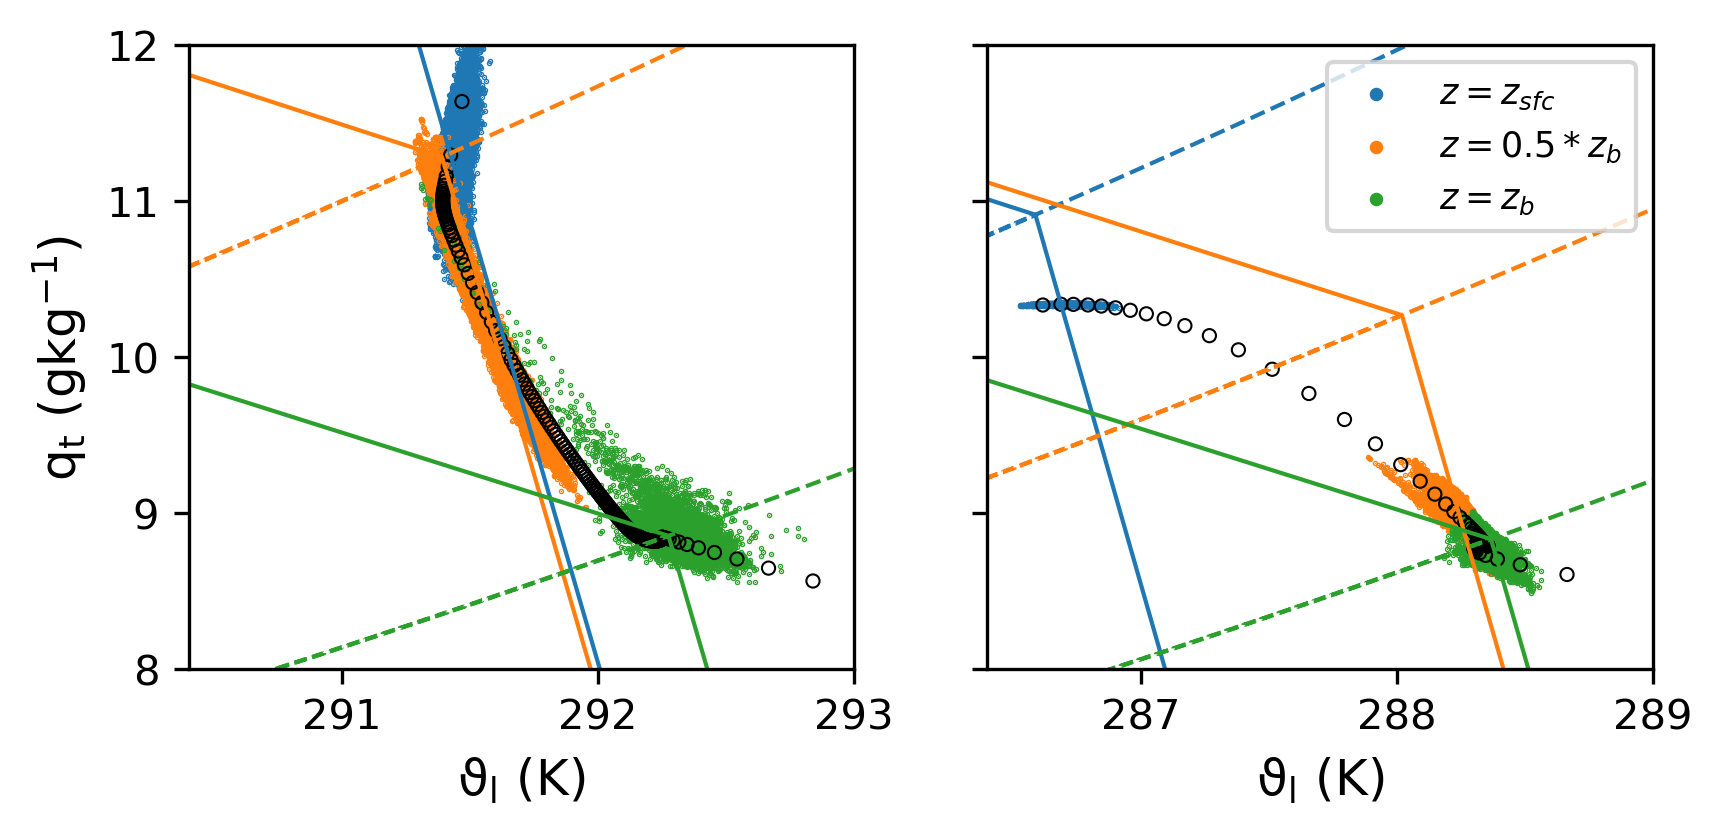

In [79]:
fig, axs = plt.subplots(ncols = 2,
                        nrows = 1,
                        sharex = False, sharey = True,
                        figsize=(16/2.54, (7)/2.54), dpi = 300)

#CADV
axs[0].set_xlabel(r"$\mathrm{\vartheta_l \ (K)}$", fontsize=myfontsize)
axs[0].set_ylabel(r"$\mathrm{q_t \ (gkg^{-1})}$", fontsize=myfontsize)
axs[0].set_xlim([290.4, 293])
axs[0].set_ylim([8., 12])

pltmixing(axs[0], pott.sel(z = z[1], method="nearest").values,
          qv.sel(z = z[1], method="nearest").values,
          p.sel(z = z[1], method="nearest").values,
          lpott_3D.sel(z = z[1], method="nearest").isel(time=0),
          qt_3D.sel(z = z[1], method="nearest").isel(time=0), 
          label = 'z = z_{sfc}')

pltmixing(axs[0], pott.sel(z = 0.5*zcb, method="nearest").values,
          qv.sel(z = 0.5*zcb, method="nearest").values,
          p.sel(z = 0.5*zcb, method="nearest").values,
          lpott_3D.sel(z = 0.5*zcb, method="nearest").isel(time=0),
          qt_3D.sel(z = 0.5*zcb, method="nearest").isel(time=0), 
          label = 'z = 0.5*z_b')

pltmixing(axs[0], pott.sel(z = zcb, method="nearest").values,
          qv.sel(z = zcb, method="nearest").values,
          p.sel(z = zcb, method="nearest").values,
          lpott_3D.sel(z = zcb, method="nearest").isel(time=0),
          qt_3D.sel(z = zcb, method="nearest").isel(time=0), 
          label = 'z = z_b')

a = axs[0].scatter(lpott,
                   1000.*qt,
                   color = 'black', s=10, facecolors='none',linewidths=0.5)

#WADV
axs[1].set_xlim([286.4, 289])
axs[1].set_xlabel(r"$\mathrm{\vartheta_l \ (K)}$", fontsize=myfontsize)

pltmixing(axs[1], pott1.sel(z = z[1], method="nearest").values,
          qv1.sel(z = z[1], method="nearest").values,
          p1.sel(z = z[1], method="nearest").values,
          lpott1_3D.sel(z = z[1], method="nearest").isel(time=0),
          qt1_3D.sel(z = z[1], method="nearest").isel(time=0), 
          label = '$z = z_{sfc}$')

pltmixing(axs[1], pott1.sel(z = 0.5*zcb1, method="nearest").values,
          qv1.sel(z = 0.5*zcb1, method="nearest").values,
          p1.sel(z = 0.5*zcb1, method="nearest").values,
          lpott1_3D.sel(z = 0.5*zcb1, method="nearest").isel(time=0),
          qt1_3D.sel(z = 0.5*zcb1, method="nearest").isel(time=0), 
          label = '$z = 0.5*z_b$')

pltmixing(axs[1], pott1.sel(z = zcb1, method="nearest").values,
          qv1.sel(z = zcb1, method="nearest").values,
          p1.sel(z = zcb1, method="nearest").values,
          lpott1_3D.sel(z = zcb1, method="nearest").isel(time=0),
          qt1_3D.sel(z = zcb1, method="nearest").isel(time=0), 
          label = '$z = z_b$')

a = axs[1].scatter(lpott1,
                   1000.*qt1,
                   color = 'black', s=10, facecolors='none',linewidths=0.5)

lgnd = axs[1].legend(frameon = True, fontsize = 0.7*myfontsize, 
#               bbox_to_anchor = (1, 0.9),
              loc = 'upper right')

lgnd.legendHandles[0]._sizes = [5]
lgnd.legendHandles[1]._sizes = [5]
lgnd.legendHandles[2]._sizes = [5]

fig.savefig('plot_result_mixingdiagram_3levels.png', dpi=fig.dpi, bbox_inches='tight')